In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pylab as plt

from mpl_toolkits.mplot3d import Axes3D

import rotate
from lassiAnalysis import regridXYZ
from utils import midPoint, gridLimits
from simulateSignal import zernikePoly
from zernikies import getZernikeCoeffs
from parabolas import rotateData, newParabola, fitLeicaData, parabola

In [3]:
def make_dish(xx, yy, f, x0, y0, z0):
    """
    """
    
    return (1./(4.*f))*(xx - x0)**2. + (1./(4.*f))*(yy - y0)**2. + z0

In [4]:
n = 32
f = 60.
x0 = 0.
y0 = 0.
z0 = -50.
thetaX = np.deg2rad(0./3600.)
thetaY = np.deg2rad(0./3600.)
x0map = 0.
y0map = 50.
xmin = -50. + x0map
xmax = 50. + x0map
ymin = -50. + y0map
ymax = 50. + y0map
dx = (xmax - xmin)/n
dy = (ymax - ymin)/n

In [5]:
grid_xy = np.mgrid[xmin:xmax:dx,
                   ymin:ymax:dy]
xx = grid_xy[0]
yy = grid_xy[1]

In [6]:
# Add noise to the grid positions.
xy_rms = 1e-6
xx_ref = xx + np.random.normal(0.0, xy_rms, xx.shape)
yy_ref = yy + np.random.normal(0.0, xy_rms, yy.shape)
xx_sig = xx + np.random.normal(0.0, xy_rms, xx.shape)
yy_sig = yy + np.random.normal(0.0, xy_rms, yy.shape)

In [7]:
# Evaluate the dish.
zz_ref = make_dish(xx_ref, yy_ref, f, x0, y0, z0)
zz_sig = make_dish(xx_sig, yy_sig, f, x0, y0, z0)

In [8]:
# Our coordinates are wrong.
xx_sig += 0.
yy_sig += 0.

In [33]:
# The Zernike polynomails is at the center of the map.
x_mid = midPoint(xx)
y_mid = midPoint(yy)
print("Dish center: {},{}".format(x_mid, y_mid))

# Zernike polynomial with an amplitude of amp.
amp = 1.7e-3
coefficient = np.zeros(37)
coefficient[14] = amp
#coefficient[4] = amp*2.
z_sim = zernikePoly(xx, yy, x_mid, y_mid, coefficients=coefficient)

# Gaussian noise to mimic the TLS noise.
tls_rms = 20e-6
z_ref_rms = np.random.normal(0.0, tls_rms, zz_ref.shape)
z_sig_rms = np.random.normal(0.0, tls_rms, zz_sig.shape)

zz_ref_dif = z_ref_rms
zz_sig_dif = z_sim + z_sig_rms

# Add the dish, TLS noise and Zernike signal.
zz_ref_tot = zz_ref + zz_ref_dif
zz_sig_tot = zz_sig + zz_sig_dif

Dish center: -1.5625,48.4375


In [34]:
xyz_sig = np.dot(rotate.invRx(thetaX), 
                 np.dot(rotate.invRy(thetaY), 
                        np.array((xx_sig.flatten(), yy_sig.flatten(), zz_sig_tot.flatten()))))
xxr_sig = xyz_sig[0]
yyr_sig = xyz_sig[1]
zzr_sig = xyz_sig[2]
xxr_sig.shape = yyr_sig.shape = zzr_sig.shape = (n,n)

In [35]:
xyz_ref = np.dot(rotate.invRx(thetaX), 
                 np.dot(rotate.invRy(thetaY), 
                        np.array((xx_ref.flatten(), yy_ref.flatten(), zz_ref_tot.flatten()))))
xxr_ref = xyz_ref[0]
yyr_ref = xyz_ref[1]
zzr_ref = xyz_ref[2]
xxr_ref.shape = yyr_ref.shape = zzr_ref.shape = (n,n)

In [36]:
def fitParabolaZernike(coeffs, x, y, z):


    L = np.array([x.flatten(), y.flatten(), z.flatten()])
    pry = (coeffs[4], coeffs[5], 0.)
    xr = rotate.PrimeX(pry, L)
    yr = rotate.PrimeY(pry, L)
    zr = rotate.PrimeZ(pry, L)

    zdata = parabola(xr, yr, coeffs[0], coeffs[1], coeffs[2], coeffs[3])
    zdata += zernikePoly(xr, yr, coeffs[6], coeffs[7], coefficients=coeffs[8:])

    return zr - zdata

In [37]:
%%time
coeffs = [60., 0., 0., -50., 0., 0.]
#coeffs = np.hstack((coeffs, [x_mid, y_mid], coefficient)) #np.zeros(37)))
#coeffs = np.hstack((coeffs, [x_mid, y_mid], np.zeros(37)))
#lb = [59., -1., -1., -51,  0.,        0.,       -10., 45.] + [-1e-2]*37
#ub = [61.,  1.,  1., -49,  np.pi/2.,  np.pi/2.,  10., 55.] + [1e-2]*37
masked_fitresult = fitLeicaData(xxr_sig, yyr_sig, zzr_sig, coeffs)#, bounds=(lb,ub), weights=None, 
                                #method=fitParabolaZernike, verbose=True)
c = masked_fitresult.x
print(c)
x_sig_fit, y_sig_fit, z_sig_fit = newParabola(xxr_sig, yyr_sig, zzr_sig, c[0], c[1], c[2], c[3], c[4], c[5])
xx_sig_rot, yy_sig_rot, zz_sig_rot = rotateData(xxr_sig, yyr_sig, zzr_sig, c[4], c[5])

[ 5.99973831e+01  7.19810039e-02 -1.38328213e-03 -5.00002406e+01
  2.72893081e-05  8.04768312e-04]
CPU times: user 13.7 ms, sys: 284 µs, total: 14 ms
Wall time: 12.6 ms


In [38]:
print(f, (c[0] - f)/f*100.)
print(x0, (c[1] - x0)/x0*100.)
print(y0, (c[2] - y0)/y0*100.)
print(z0, (c[3] - z0)/z0*100.)
print(thetaX, (c[4] - thetaX)/thetaX*100.)
print(thetaY, (c[5] - thetaY)/thetaY*100.)

60.0 -0.004361548054265067
0.0 inf
0.0 -inf
-50.0 0.00048129631572635384
0.0 inf
0.0 inf


In [39]:
masked_fitresult = fitLeicaData(xxr_ref, yyr_ref, zzr_ref, [60., 0., 0., -50., 0., 0.], weights=None)
cr = masked_fitresult.x
print(cr)
x_ref_fit, y_ref_fit, z_ref_fit = newParabola(xxr_ref, yyr_ref, zzr_ref, 
                                              cr[0], cr[1], cr[2], cr[3], cr[4], cr[5])
xx_ref_rot, yy_ref_rot, zz_ref_rot = rotateData(xxr_ref, yyr_ref, zzr_ref, cr[4], cr[5])

[ 5.99999872e+01 -1.28822097e-05  1.99540824e-05 -4.99999982e+01
 -7.36084950e-08 -1.36538733e-07]


In [40]:
print(f, (cr[0] - f)/f*100.)
print(x0, (cr[1] - x0)/x0*100.)
print(y0, (cr[2] - y0)/y0*100.)
print(z0, (cr[3] - z0)/z0*100.)
print(thetaX, (cr[4] - thetaX)/thetaX*100.)
print(thetaY, (cr[5] - thetaY)/thetaY*100.)

60.0 -2.1335389455146014e-05
0.0 -inf
0.0 inf
-50.0 -3.608784467701298e-06
0.0 -inf
0.0 -inf


In [41]:
#print((c - cr)/c*100.)

<IPython.core.display.Javascript object>


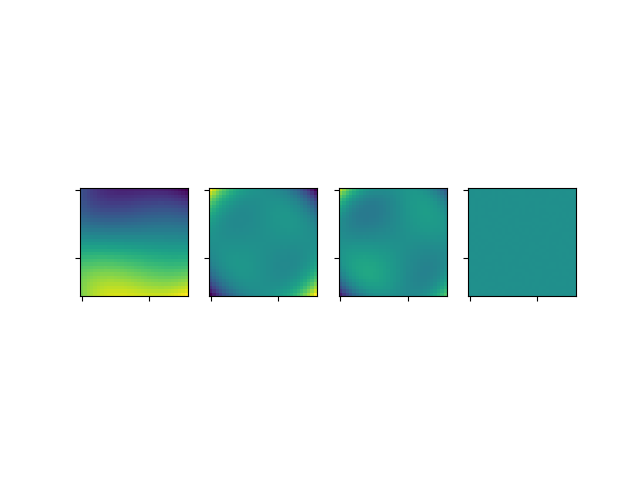

[]

In [42]:
plt.figure()

plt.subplot(141)
z_sig_fit.shape = (n,n)
plt.imshow(zz_sig_tot - z_sig_fit)
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

plt.subplot(142)
plt.imshow(zz_sig_dif, vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

plt.subplot(143)
zz_sig_rot.shape = (n,n)
plt.imshow(zz_sig_rot - z_sig_fit, vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

plt.subplot(144)
zz_ref_rot.shape = (n,n)
z_ref_fit.shape = (n,n)
plt.imshow(zz_ref_rot - z_ref_fit, vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

In [43]:
xx_sig_rot.shape = (n,n)
yy_sig_rot.shape = (n,n)
zz_sig_rot.shape = (n,n)
z_sig_fit.shape = (n,n)

xx_ref_rot.shape = (n,n)
yy_ref_rot.shape = (n,n)
zz_ref_rot.shape = (n,n)
z_ref_fit.shape = (n,n)

diff_ref = zz_ref_rot - z_ref_fit
diff_sig = zz_sig_rot - z_sig_fit

<IPython.core.display.Javascript object>


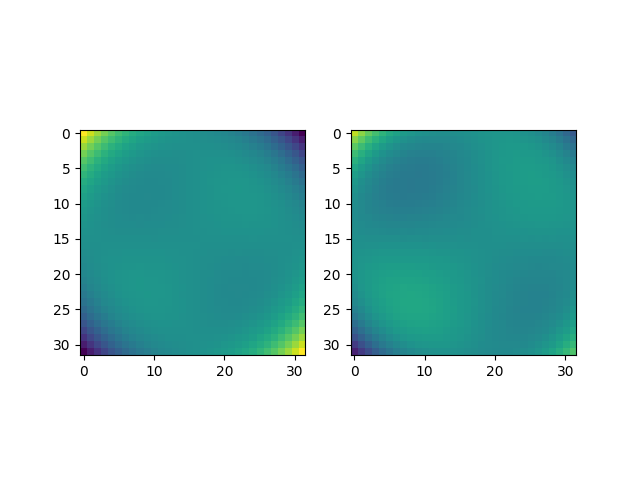

In [44]:
plt.figure()

plt.subplot(121)
plt.imshow(zz_sig_dif, vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))

plt.subplot(122)

plt.imshow((zz_sig_rot - z_sig_fit) - (zz_ref_rot - z_ref_fit), 
           vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))

In [45]:
xmin, xmax = gridLimits(xx_ref_rot, xx_sig_rot)
ymin, ymax = gridLimits(yy_ref_rot, yy_sig_rot)

xxrr,yyrr,zzrr = regridXYZ(xx_ref_rot, yy_ref_rot, diff_ref, 
                           n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

xxsr,yysr,zzsr = regridXYZ(xx_sig_rot, yy_sig_rot, diff_sig, 
                           n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

<IPython.core.display.Javascript object>


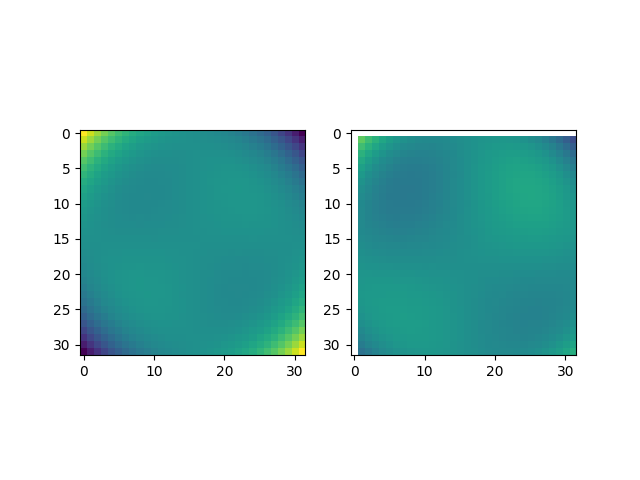

In [46]:
plt.figure()

plt.subplot(121)
plt.imshow(zz_sig_dif, vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))

plt.subplot(122)
plt.imshow((zzsr - zzrr), vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))

<IPython.core.display.Javascript object>


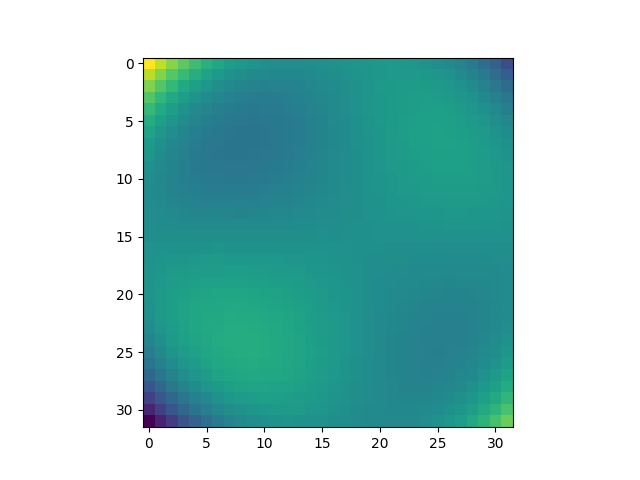

In [47]:
diff = (zz_sig_rot - z_sig_fit) - (zz_ref_rot - z_ref_fit)

plt.figure()

plt.imshow(diff)

<IPython.core.display.Javascript object>


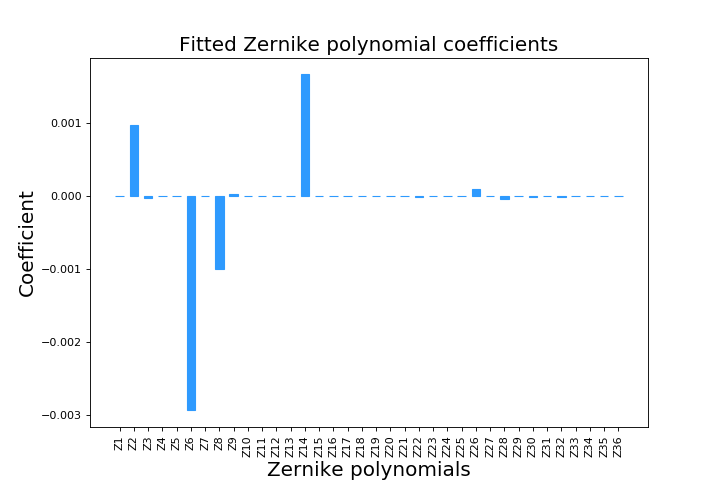

CPU times: user 361 ms, sys: 7.13 ms, total: 368 ms
Wall time: 364 ms


In [48]:
%%time

fitlist = getZernikeCoeffs(diff.T, 36, barChart=True, norm='active-surface')

In [49]:
np.mean(z_sim)

6.776263578034403e-21

In [50]:
np.mean(np.power(z_sim, 2.))

1.0017735724298357e-05

In [51]:
amp

0.0017

<IPython.core.display.Javascript object>


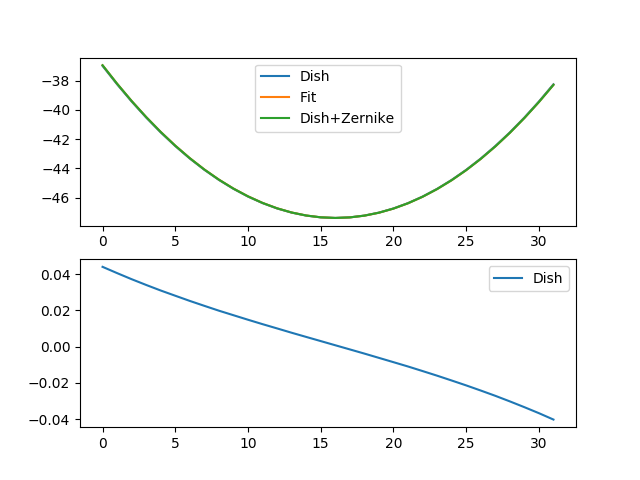

In [52]:
plt.figure()

plt.subplot(211)
plt.plot(zz_sig[:,n//4], label='Dish')
plt.plot(z_sig_fit[:,n//4], label='Fit')
plt.plot(zz_sig_rot[:,n//4], label='Dish+Zernike')
plt.legend(loc=0, fancybox=True)

plt.subplot(212)
plt.plot(zz_sig_rot[:,n//4] - zz_sig[:,n//4], label='Dish')
plt.legend(loc=0, fancybox=True)